In [1]:
import numpy as np
import pandas as pd
import os
os.listdir()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from plotly import express as px
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, model_from_json
import datetime
from os.path import exists
np.random.seed(0)

from sklearn.preprocessing import MinMaxScaler

In [2]:
items = pd.read_csv("../files/items.csv")
item_categories = pd.read_csv("../files/item_categories.csv")
sales = pd.read_csv("../files/sales_train.csv")
sample_submission = pd.read_csv("../files/sample_submission.csv")
shops = pd.read_csv("../files/shops.csv")
test = pd.read_csv("../files/test.csv")
#train =pd.read_csv("../files/train.csv")

In [3]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)
train['date'] = pd.to_datetime(train['date'])
train['sales'] = train['item_cnt_day']*train['item_price']

## Getting time related variables
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['yearmo'] = train['year']*100+train['month']

train['weekday'] = train['date'].dt.dayofweek
train['day'] = train['date'].dt.day

In [4]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,sales,year,month,yearmo,weekday,day
0,2013-02-01,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,999.00,2013,2,201302,4,1
1,2013-03-01,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,899.00,2013,3,201303,4,1
2,2013-05-01,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,-899.00,2013,5,201305,2,1
3,2013-06-01,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум""",Музыка - Винил,1709.05,2013,6,201306,5,1
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум""",Музыка - CD фирменного производства,1099.00,2013,1,201301,1,15


#### Getting top of each category

In [6]:
for i in ['shop_id', 'item_id', 'item_category_id']:
    print('Unique ' + i + 's ' + str(train[i].nunique()))
    groupDf = train.groupby([i], as_index = False).sum()[[i, 'sales']].sort_values(['sales'], ascending = False)
    groupDf['prec_sales'] = np.round(groupDf['sales']*100/groupDf['sales'].sum(),2)
    groupDf['prec_sales_cumsum'] = groupDf['prec_sales'].cumsum()
    groupDf['prec_sales_cumsum_flag'] = [1 if prec < 80 else 0 for prec in groupDf['prec_sales_cumsum']]
    print(i + 's Constributing to 80% of Sales : ' + str(round(groupDf['prec_sales_cumsum_flag'].sum()*100/groupDf['prec_sales_cumsum_flag'].count(),2)) + '%')
    if groupDf.shape[0] > 100:
        groupDf = groupDf.iloc[range(0,100),]
    groupDf = groupDf[groupDf['sales']!=0]
    fig = px.treemap(groupDf, path=[px.Constant(i), i], values='sales',
                    color = 'sales', hover_data=['prec_sales'],
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(groupDf[i], weights=groupDf[i]))
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    fig.show()

Unique shop_ids 60
shop_ids Constributing to 80% of Sales : 48.33%


Unique item_ids 21807
item_ids Constributing to 80% of Sales : 7.92%


Unique item_category_ids 84
item_category_ids Constributing to 80% of Sales : 22.62%


#### Sales Trends

In [7]:
train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name', 'item_category_id', 'shop_name',
       'item_category_name', 'sales', 'year', 'month', 'yearmo', 'weekday',
       'day'],
      dtype='object')

In [8]:
overallTrend = train.groupby(['date'], as_index = False).sum()[['date', 'sales']]
fig = px.line(overallTrend, x="date", y="sales", title='Daily Sales Trend')
fig.show()

overallTrend = train.groupby(['yearmo'], as_index = False).sum()[['yearmo', 'sales']]
overallTrend['yearmo'] = overallTrend['yearmo'].astype(str)
fig = px.line(overallTrend, x="yearmo", y="sales", title='Monthly Sales Trend')
fig.show()

overallTrend = train.groupby(['day'], as_index = False).mean()[['day', 'sales']]
overallTrend['day'] = overallTrend['day'].astype(str)
fig = px.line(overallTrend, x="day", y="sales", title='Day Trend')
fig.show()

overallTrend = train.groupby(['weekday'], as_index = False).mean()[['weekday', 'sales']]
overallTrend['weekday'] = overallTrend['weekday'].astype(str)
fig = px.line(overallTrend, x="weekday", y="sales", title='Weekday Trend')
fig.show()

- Spike observed every december
- 2015 post oct data seems to be not captured completely and can be excluded from modeling
- Low sales at the beginning of the month
- Low on weekends

### Consistency check

#### Count Trends

In [9]:
overallTrend = train.groupby(['yearmo'], as_index = False).sum()[['yearmo', 'sales']]
overallTrend['yearmo'] = overallTrend['yearmo'].astype(str)
fig = px.line(overallTrend, x="yearmo", y="sales", title='Monthly Sales Trend')
fig.show()

In [10]:
overallTrend = train.groupby(['yearmo'], as_index = False).nunique()[['yearmo', 'shop_id']]
overallTrend['yearmo'] = overallTrend['yearmo'].astype(str)
fig = px.line(overallTrend, x="yearmo", y="shop_id", title='Count of Shop')
fig.update_yaxes(rangemode="tozero")
fig.show()

overallTrend = train.groupby(['yearmo'], as_index = False).nunique()[['yearmo', 'item_id']]
overallTrend['yearmo'] = overallTrend['yearmo'].astype(str)
fig = px.line(overallTrend, x="yearmo", y="item_id", title='Count of Items')
fig.update_yaxes(rangemode="tozero")
fig.show()

overallTrend = train.groupby(['yearmo'], as_index = False).nunique()[['yearmo', 'item_category_id']]
overallTrend['yearmo'] = overallTrend['yearmo'].astype(str)
fig = px.line(overallTrend, x="yearmo", y="item_category_id", title='Count of Categories')
fig.update_yaxes(rangemode="tozero")
fig.show()

- Number of stores and category sold are consistent across time while items sold are reducing drastically

#### Rolling up data for final modeling

- Rolling at yearmo, store, item level for reducting datasize

In [10]:
trainGroup = train.groupby(['date', 'shop_id', 'month'], as_index = False).sum()[['date', 'shop_id', 'month', 'item_cnt_day', 'sales']]

In [11]:
trainGroup.head()

,date,shop_id,month,item_cnt_day,sales
0,2013-01-01,2,1,24.0,31886.0
1,2013-01-01,7,1,89.0,59993.0
2,2013-01-01,8,1,50.0,44516.0
3,2013-01-01,13,1,31.0,6043.0
4,2013-01-01,14,1,66.0,48847.0


- Preparing train data with lag and window columns
- Replacing NAs created post lag with zero

In [12]:
updatedTrain = trainGroup.copy()

In [13]:
cols = ['sales']
lagDays = 30
windowDays = 1
for col in cols:
    for i in range(1, lagDays+1):
        updatedTrain[col+"_lagt_"+str(i)] = updatedTrain[col].shift(i)
    updatedTrain[col+'_wint_'+str(windowDays)] = updatedTrain[col].shift(-windowDays)  
    
updatedTrain = updatedTrain.fillna(0)

In [14]:
## Exluding outlier data and splitting test and train
## Test for 3 months
testData = updatedTrain[(updatedTrain['date'] >= '2015-06-01') & (updatedTrain['date'] <= '2015-08-31')]
xTest = testData.drop(['sales_wint_%s'%(windowDays)], axis = 1)
yTest = testData['sales_wint_%s'%(windowDays)]
## Train exluding test period
updatedTrain = updatedTrain[updatedTrain['date'] < '2015-06-01']

In [15]:
xTest = testData.drop(['sales_wint_%s'%(windowDays)], axis = 1)
yTest = testData['sales_wint_%s'%(windowDays)]

- Creating train and validation dataset

In [16]:
xTrain, xValid, yTrain, yValid = train_test_split(updatedTrain.drop(['sales_wint_%s'%(windowDays)], axis = 1), updatedTrain['sales_wint_%s'%(windowDays)], test_size=0.1, random_state=0)

In [17]:
xTrain.head()

,date,shop_id,month,item_cnt_day,sales,sales_lagt_1,sales_lagt_2,sales_lagt_3,sales_lagt_4,sales_lagt_5,...,sales_lagt_21,sales_lagt_22,sales_lagt_23,sales_lagt_24,sales_lagt_25,sales_lagt_26,sales_lagt_27,sales_lagt_28,sales_lagt_29,sales_lagt_30
5070,2013-04-25,3,4,9.0,4692.0,11979.0,5845.00,34181.0,104111.0,20370.0,...,35234.0,104221.0,24267.0,27899.0,63006.0,52460.0,42720.0,149954.0,42860.0,36814.0
4413,2013-04-09,55,4,16.0,7868.0,86873.0,41089.00,40684.0,23131.0,61109.0,...,119750.0,184949.0,111718.0,118657.0,34579.0,29902.0,61623.0,31306.0,55250.0,45234.0
32164,2014-11-26,14,11,33.0,74571.0,178049.0,28114.35,67779.0,90775.0,50186.0,...,68648.0,73672.0,35550.0,29691.0,31428.0,184887.0,32866.0,4776.0,22876.0,152769.0
13170,2013-10-24,5,10,25.0,14105.0,46160.0,11289.00,16201.0,41282.0,65899.0,...,25833.0,14216.0,17475.0,168269.0,19650.0,23820.0,44722.0,64196.0,35207.0,125338.0
31807,2014-11-18,59,11,99.0,240837.0,49932.0,97921.00,169399.0,117916.0,446346.0,...,143689.0,203063.0,278434.0,58227.0,23471.0,881474.0,258270.0,221426.0,402669.0,427481.0


#### Building MLP model

In [177]:
batchSize = 24
lr_ = 0.01
model_epocs = 150
adamOpt = optimizers.Adam(lr_)

mlpModel = Sequential()
mlpModel.add(Dense(100, activation='elu', input_dim=xTrain.drop(['date', 'shop_id', 'item_cnt_day', 'sales'], axis = 1).shape[1]))
mlpModel.add(Dense(80, activation='relu'))
mlpModel.add(Dense(90, activation='relu'))
mlpModel.add(Dense(70, activation='relu'))

















mlpModel.add(Dropout(0.1))
mlpModel.add(Dense(60, activation='relu'))
mlpModel.add(Dense(50, activation='relu'))
mlpModel.add(Dense(30, activation='relu'))
mlpModel.add(Dense(10, activation='relu'))
mlpModel.add(Dense(1))
mlpModel.compile(loss='mse', optimizer=adamOpt)
mlpModel.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_94 (Dense)            (None, 100)               3100      
                                                                 
 dense_95 (Dense)            (None, 80)                8080      
                                                                 
 dense_96 (Dense)            (None, 90)                7290      
                                                                 
 dense_97 (Dense)            (None, 70)                6370      
                                                                 
 dropout_12 (Dropout)        (None, 70)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                4260      
                                                                 
 dense_99 (Dense)            (None, 50)              

In [153]:
# import tensorflow as tf
# tf.config.run_functions_eagerly(True)

In [154]:
mlp_history = mlpModel.fit(xTrain.drop(['date', 'shop_id', 'item_cnt_day', 'sales'], axis = 1).values, yTrain, validation_data=(xValid.drop(['date', 'shop_id', 'item_cnt_day', 'sales', 'scaledSales'], axis = 1).values, yValid), epochs=model_epocs, verbose=2)

Epoch 1/150
1132/1132 - 3s - loss: 8064171520.0000 - val_loss: 7833228800.0000 - 3s/epoch - 2ms/step
Epoch 2/150
1132/1132 - 2s - loss: 7544777728.0000 - val_loss: 7298025472.0000 - 2s/epoch - 2ms/step
Epoch 3/150
1132/1132 - 2s - loss: 7461391360.0000 - val_loss: 7518214144.0000 - 2s/epoch - 2ms/step
Epoch 4/150
1132/1132 - 2s - loss: 7353029632.0000 - val_loss: 8338753536.0000 - 2s/epoch - 2ms/step
Epoch 5/150
1132/1132 - 2s - loss: 7400132096.0000 - val_loss: 7336562176.0000 - 2s/epoch - 2ms/step
Epoch 6/150
1132/1132 - 2s - loss: 7387932672.0000 - val_loss: 7486866432.0000 - 2s/epoch - 2ms/step
Epoch 7/150
1132/1132 - 2s - loss: 7266538496.0000 - val_loss: 7378964480.0000 - 2s/epoch - 2ms/step
Epoch 8/150
1132/1132 - 2s - loss: 7243979264.0000 - val_loss: 7420121600.0000 - 2s/epoch - 2ms/step
Epoch 9/150
1132/1132 - 2s - loss: 7208645632.0000 - val_loss: 7724742656.0000 - 2s/epoch - 2ms/step
Epoch 10/150
1132/1132 - 2s - loss: 7262072320.0000 - val_loss: 7707934208.0000 - 2s/epoch 

Epoch 82/150
1132/1132 - 2s - loss: 6907889664.0000 - val_loss: 6924241920.0000 - 2s/epoch - 2ms/step
Epoch 83/150
1132/1132 - 2s - loss: 6053367296.0000 - val_loss: 6524151296.0000 - 2s/epoch - 2ms/step
Epoch 84/150
1132/1132 - 2s - loss: 5776075776.0000 - val_loss: 6665080832.0000 - 2s/epoch - 2ms/step
Epoch 85/150
1132/1132 - 2s - loss: 5910874624.0000 - val_loss: 9740605440.0000 - 2s/epoch - 2ms/step
Epoch 86/150
1132/1132 - 2s - loss: 6487583232.0000 - val_loss: 7345958912.0000 - 2s/epoch - 2ms/step
Epoch 87/150
1132/1132 - 2s - loss: 6251676672.0000 - val_loss: 6786205184.0000 - 2s/epoch - 2ms/step
Epoch 88/150
1132/1132 - 2s - loss: 6120535552.0000 - val_loss: 6716107264.0000 - 2s/epoch - 2ms/step
Epoch 89/150
1132/1132 - 2s - loss: 5864667136.0000 - val_loss: 6495474176.0000 - 2s/epoch - 2ms/step
Epoch 90/150
1132/1132 - 2s - loss: 5824112128.0000 - val_loss: 6441218560.0000 - 2s/epoch - 2ms/step
Epoch 91/150
1132/1132 - 2s - loss: 5644648960.0000 - val_loss: 7753913344.0000 - 

In [155]:
modelName = 'mlpModel_scaled_data_'+str(datetime.datetime.now()).replace('.', '_').replace(':', '_')

In [156]:
# serialize model to JSON
model_json = mlpModel.to_json()
with open("../models/{}.json".format(modelName), "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
mlpModel.save_weights("../models/{}.h5".format(modelName))
print("Saved model to disk")

Saved model to disk


In [157]:
# load json and create model
json_file = open('../models/{}.json'.format(modelName), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("../models/{}.h5".format(modelName))
print("Loaded model from disk")

Loaded model from disk


In [21]:
def resultsSummary(x, y, predVal, predFlag):
    '''
    Module returns average percentage error of monthly store sales
    x: xTrain
    y: actual
    predVal: model predicted sales
    
    Return average error (MAPE, MSE at store-month level) and reults dataframe
    '''
    df = pd.DataFrame()
    df['date'] = x['date']
    df['act'] = y
    df['pred'] = predVal

    ## Getting time related variables
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['yearmo'] = df['year']*100+df['month']
    df['shop_id'] = x['shop_id']

    helperDf = df.groupby(['yearmo', 'shop_id'], as_index = False).sum()[['shop_id', 'yearmo', 'act', 'pred']]
    helperDf['precError'] = (helperDf['act'] - helperDf['pred'])/helperDf['act']
    helperDf['absPrecError'] = np.abs((helperDf['act'] - helperDf['pred'])/helperDf['act'])
    helperDf['sqrdError'] = np.sqrt(np.square(helperDf['act'] - helperDf['pred']))
    helperDf['Flag'] = predFlag
    
    return np.mean(np.abs(helperDf['precError'])), np.mean(helperDf['sqrdError']), helperDf

#### Evaluation on test and train datasets

In [283]:
precErrorTrain, mseTrain, storeMonthResultsTrain = resultsSummary(xTrain, yTrain, loaded_model.predict(xTrain.drop(['date', 'shop_id', 'item_cnt_day', 'sales'], axis = 1).values), 'Train')
precErrorTest, mseTest, storeMonthResultsTest = resultsSummary(xTest, yTest, loaded_model.predict(xTest.drop(['date', 'shop_id', 'item_cnt_day', 'sales'], axis = 1).values), 'Test')
precErrorValid, mseValid, storeMonthResultsValid = resultsSummary(xValid, yValid, loaded_model.predict(xValid.drop(['date', 'shop_id', 'item_cnt_day', 'sales'], axis = 1).values), 'Test')

126/126 [==============================] - 0s 2ms/step


#### Saving results to desk in a rep

In [160]:
from os.path import exists

In [161]:
modelResultsFile = '../outputs/MLP_Iteration_results.xlsx'

### Creating if doesnt exist else append to existing file
if exists(modelResultsFile):
    fileData = pd.read_excel(modelResultsFile)
    fileData = fileData.append(pd.DataFrame([{'modelName': modelName, 'trainMAPE': precErrorTrain, 'trainMSE': mseTrain, 'testMAPE': precErrorTest, 'testMSE': mseTest, 'validMAPE': precErrorValid, 'validMSE': mseValid}]))
    fileData.to_excel(modelResultsFile, index=False)
else:
    fileData = pd.DataFrame([{'modelName': modelName, 'trainMAPE': precErrorTrain, 'trainMSE': mseTrain, 'testMAPE': precErrorTest, 'testMSE': mseTest, 'validMAPE': precErrorValid, 'validMSE': mseValid}])
    fileData.to_excel(modelResultsFile, index=False)


In [162]:
print(precErrorTrain)
print(precErrorValid)
print(precErrorTest)

0.9284285152862884
1.1113423905837596
1.0413736100586644


In [114]:
print(precErrorTrain)
print(precErrorTest)

0.7572061301821488
0.7174712140189708


#### Plotting actual vs pred on final model

In [18]:
# load json and create model
json_file = open('../models/{}.json'.format('lstmModel_2022-11-26 16_00_14_624793'), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("../models/{}.h5".format('lstmModel_2022-11-26 16_00_14_624793'))
print("Loaded model from disk")

Loaded model from disk


In [24]:
precErrorTrain, mseTrain, storeMonthResultsTrain = resultsSummary(xTrain, yTrain, loaded_model.predict(xTrain.drop(['date', 'shop_id', 'item_cnt_day', 'sales', 'month'], axis = 1).values), 'Train')
precErrorTest, mseTest, storeMonthResultsTest = resultsSummary(xTest, yTest, loaded_model.predict(xTest.drop(['date', 'shop_id', 'item_cnt_day', 'sales', 'month'], axis = 1).values), 'Test')
precErrorValid, mseValid, storeMonthResultsValid = resultsSummary(xValid, yValid, loaded_model.predict(xValid.drop(['date', 'shop_id', 'item_cnt_day', 'sales', 'month'], axis = 1).values), 'Test')

126/126 [==============================] - 0s 3ms/step


In [25]:
print(precErrorTrain)
print(precErrorValid)
print(precErrorTest)

0.6752769897048267
0.8842681151488064
0.6779111664372024


shop_id: 0


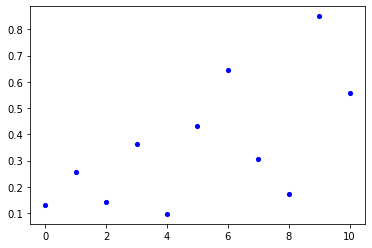

shop_id: 1


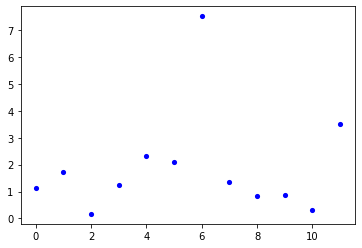

shop_id: 2


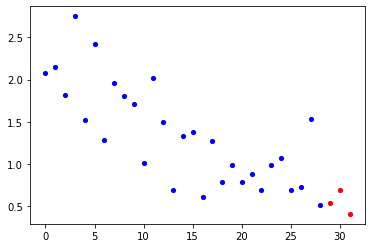

shop_id: 3


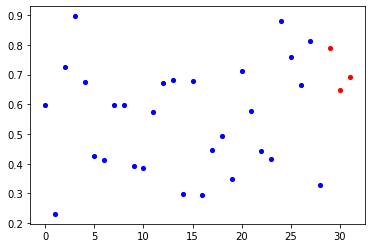

shop_id: 4


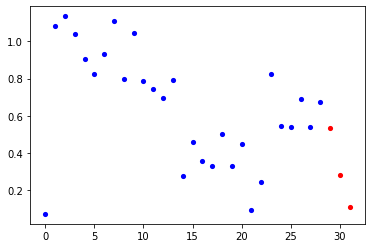

shop_id: 5


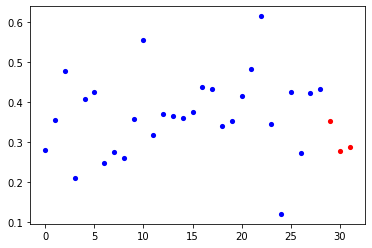

shop_id: 6


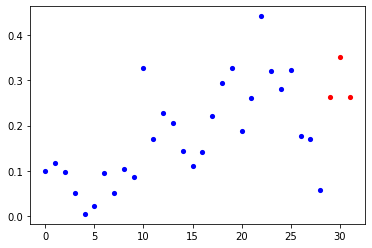

shop_id: 7


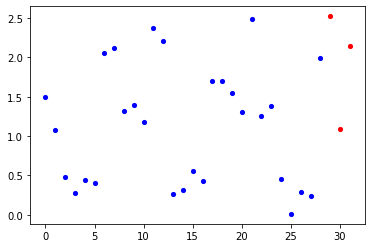

shop_id: 8


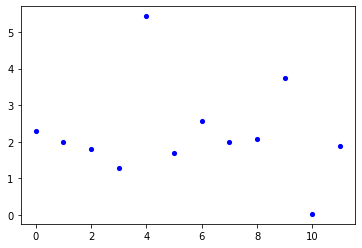

shop_id: 10


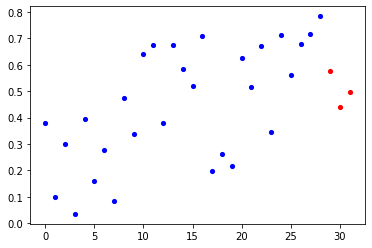

shop_id: 12


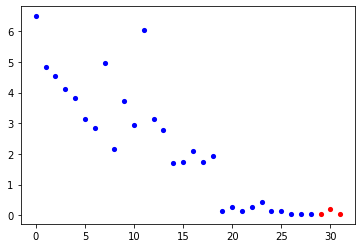

shop_id: 13


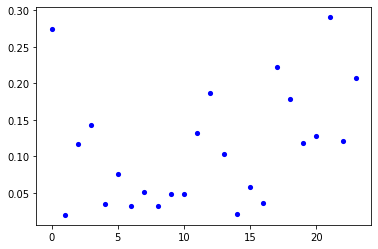

shop_id: 14


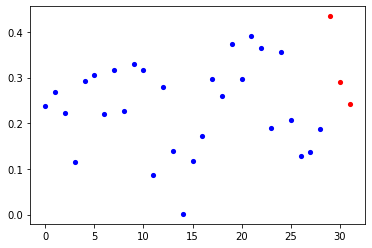

shop_id: 15


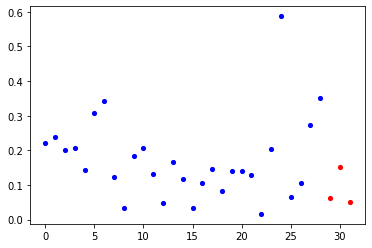

shop_id: 16


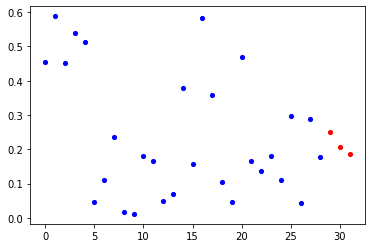

shop_id: 17


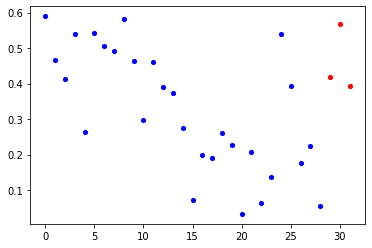

shop_id: 18


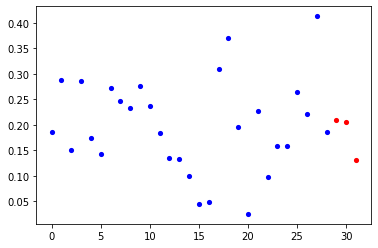

shop_id: 19


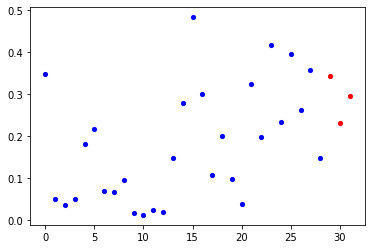

shop_id: 21


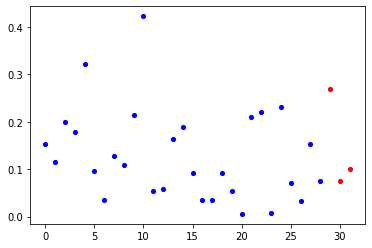

shop_id: 22


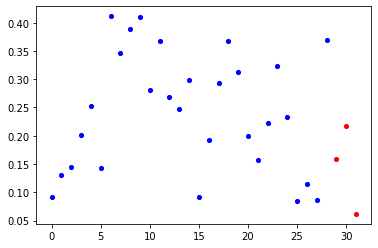

shop_id: 23


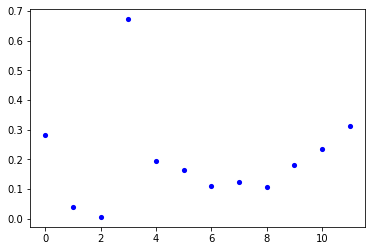

shop_id: 24


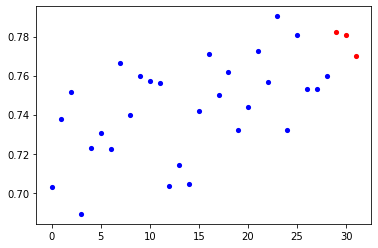

shop_id: 25


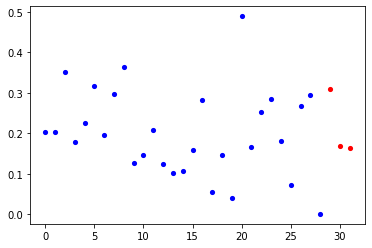

shop_id: 26


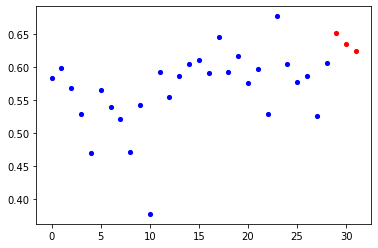

shop_id: 27


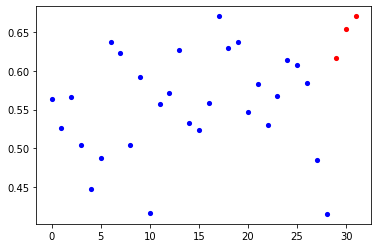

shop_id: 28


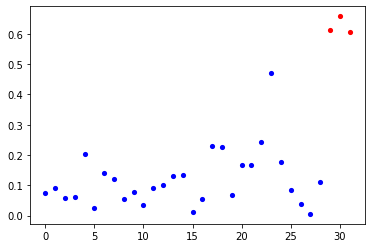

shop_id: 29


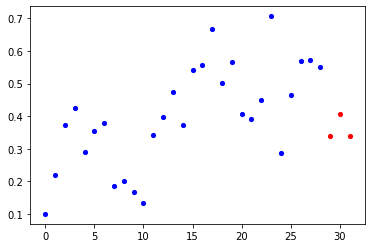

shop_id: 30


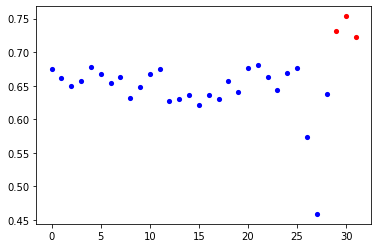

shop_id: 31


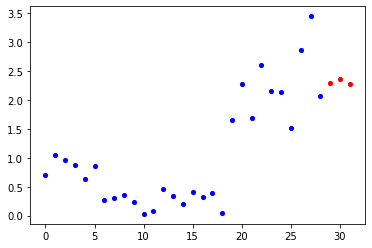

shop_id: 32


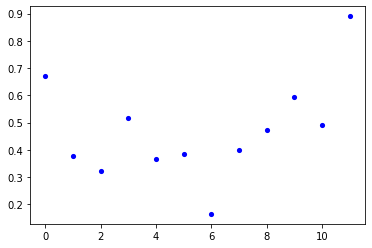

shop_id: 35


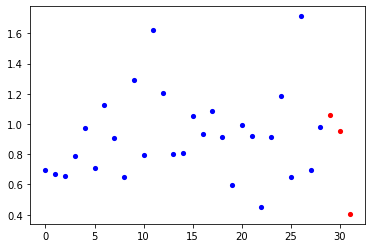

shop_id: 37


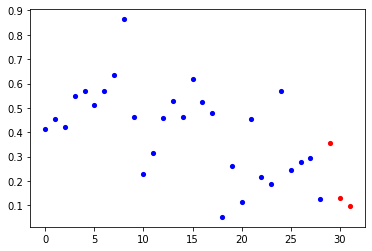

shop_id: 38


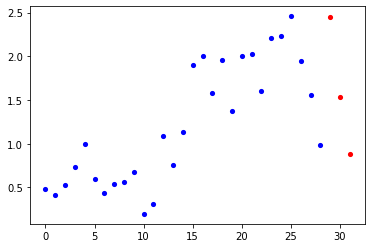

shop_id: 41


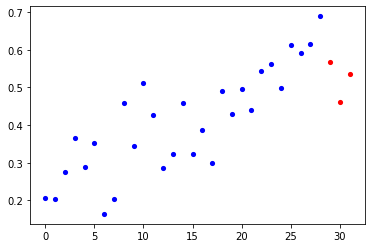

shop_id: 42


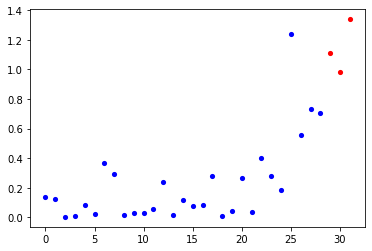

shop_id: 43


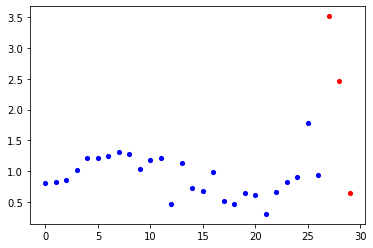

shop_id: 44


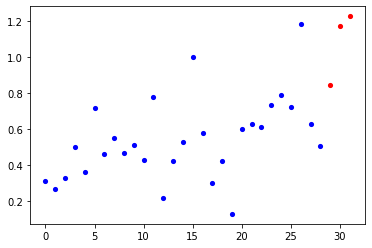

shop_id: 45


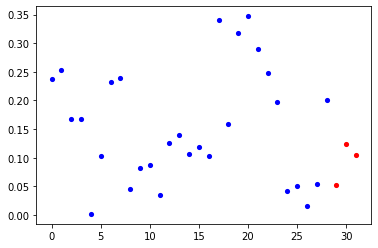

shop_id: 46


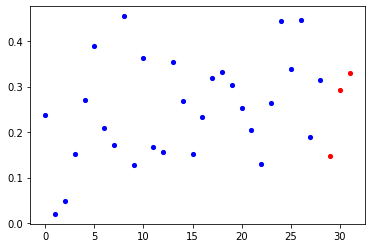

shop_id: 47


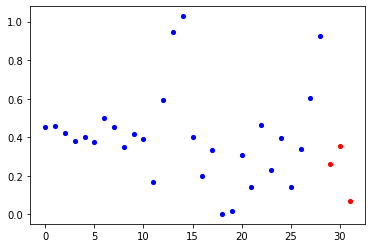

shop_id: 50


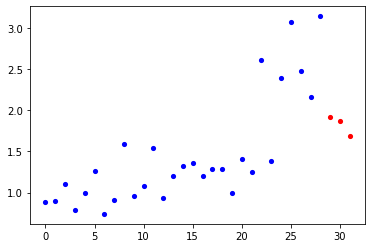

shop_id: 51


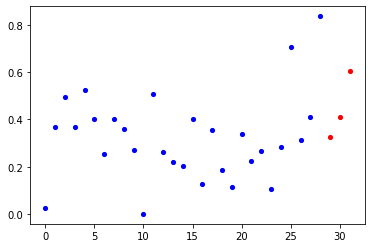

shop_id: 52


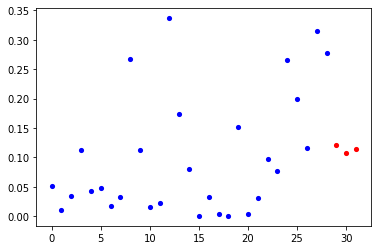

shop_id: 53


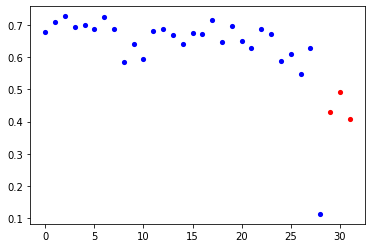

shop_id: 54


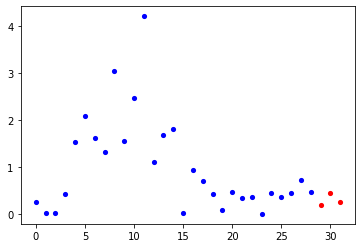

shop_id: 55


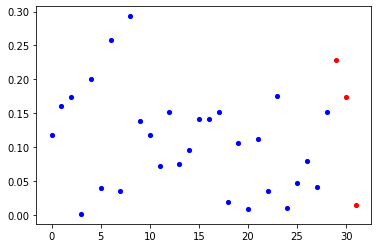

shop_id: 56


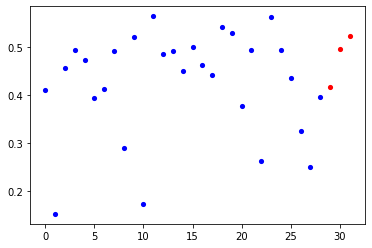

shop_id: 57


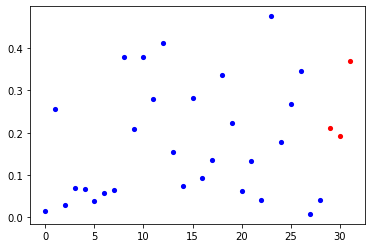

shop_id: 58


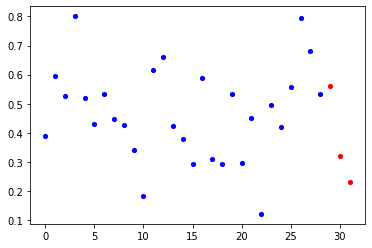

shop_id: 59


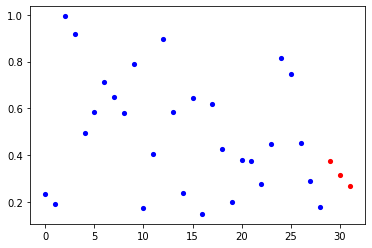

shop_id: 9


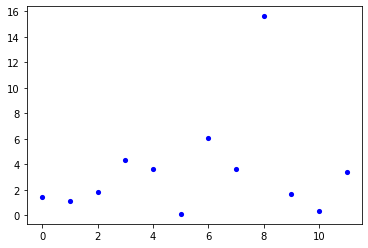

shop_id: 49


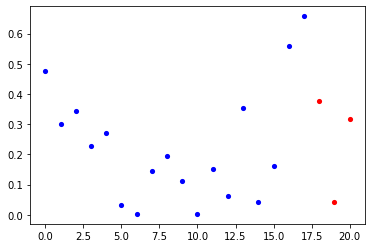

shop_id: 33


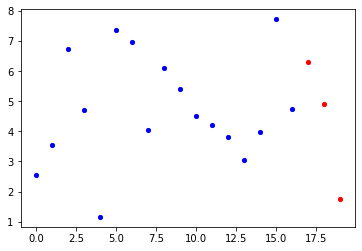

shop_id: 34


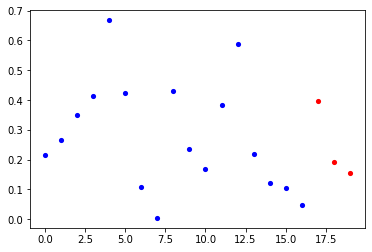

shop_id: 39


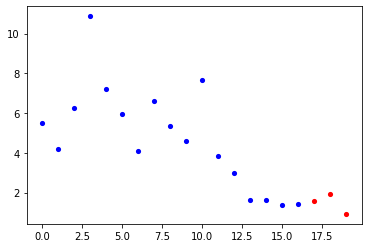

shop_id: 40


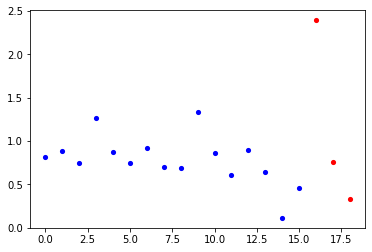

shop_id: 48


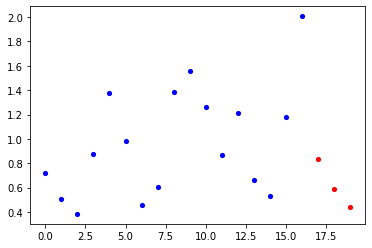

shop_id: 20


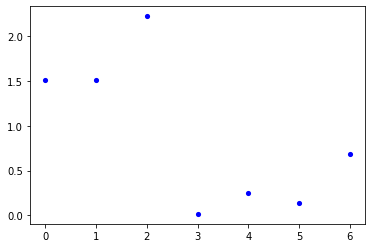

shop_id: 11


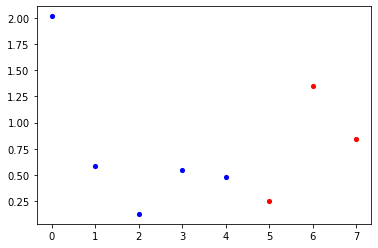

In [26]:
for i in storeMonthResultsTrain['shop_id'].unique():
    p = storeMonthResultsTrain.append(storeMonthResultsTest)
    p['precError'] = np.abs(p['precError'])
    p = p[p['shop_id']==i]
    print('shop_id: %s'%(i))
    for j in range(p.shape[0]):
        if list(p['Flag'])[j] == 'Train':
            col = 'blue'
        else:
            col = 'red'
            
        #print(j)
        #print(list(p['precError'])[j])
        plt.scatter(j, list(p['precError'])[j], c = col, s = 10,linewidth = 2)
    plt.show()

shop_id: 0


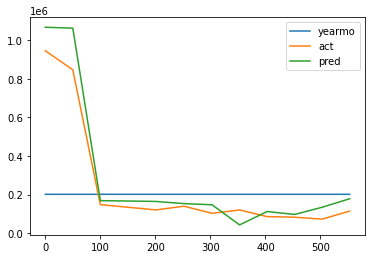

shop_id: 1


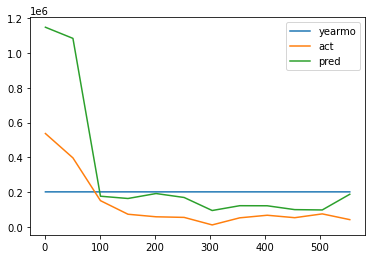

shop_id: 2


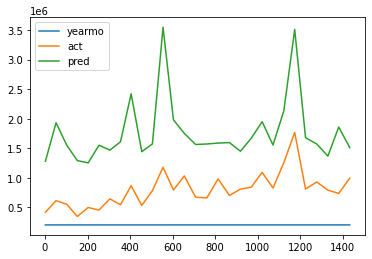

shop_id: 3


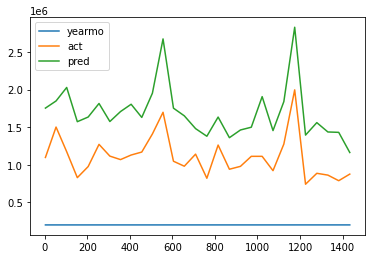

shop_id: 4


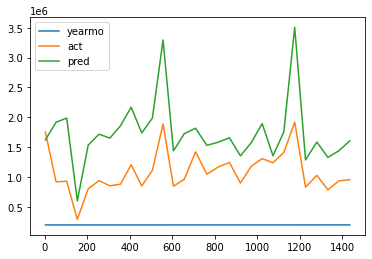

shop_id: 5


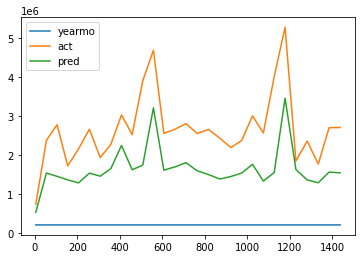

shop_id: 6


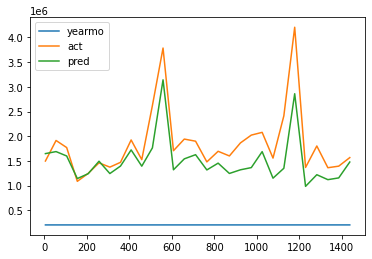

shop_id: 7


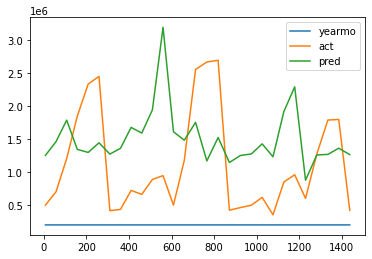

shop_id: 8


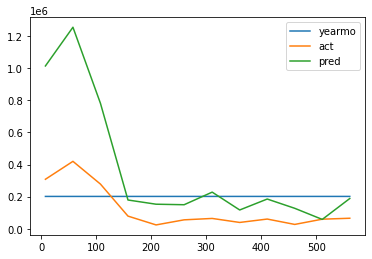

shop_id: 10


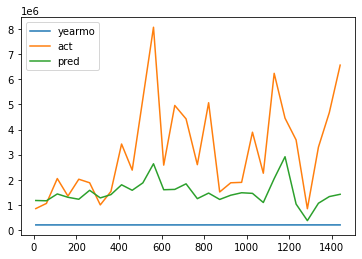

shop_id: 12


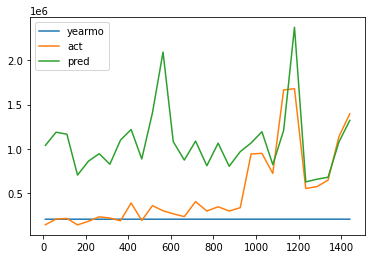

shop_id: 13


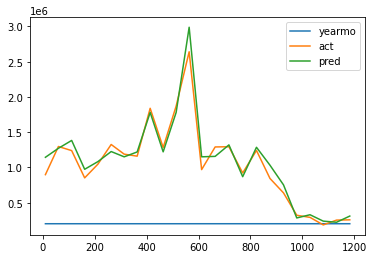

shop_id: 14


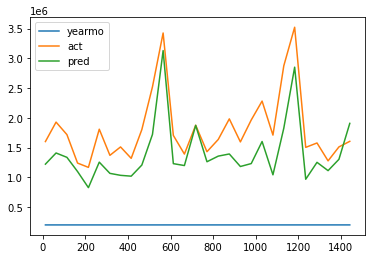

shop_id: 15


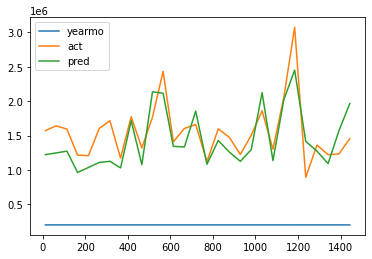

shop_id: 16


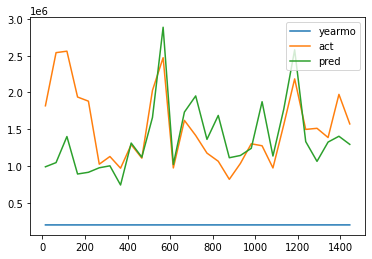

shop_id: 17


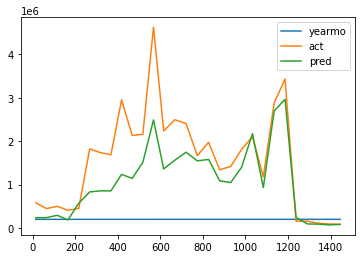

shop_id: 18


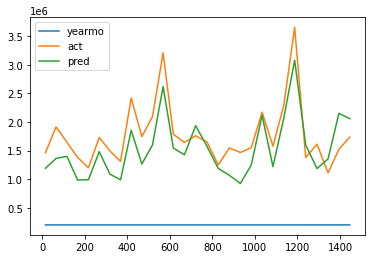

shop_id: 19


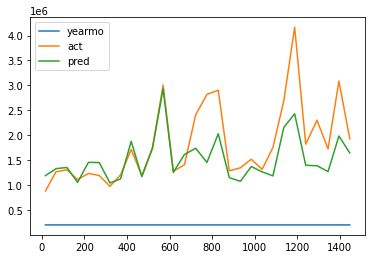

shop_id: 21


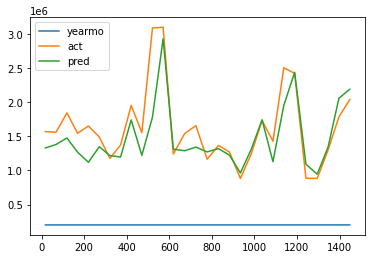

shop_id: 22


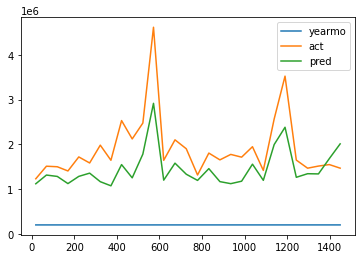

shop_id: 23


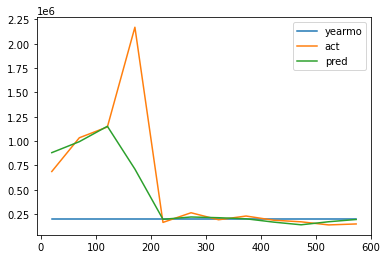

shop_id: 24


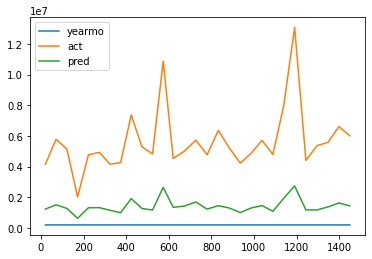

shop_id: 25


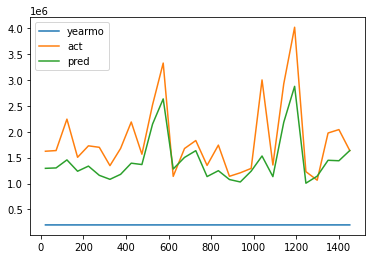

shop_id: 26


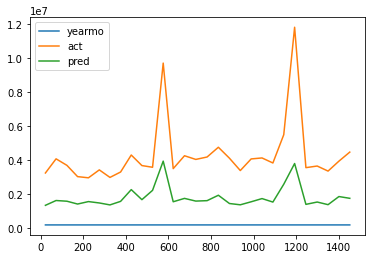

shop_id: 27


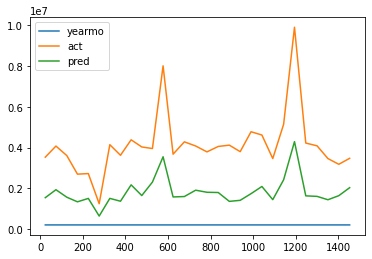

shop_id: 28


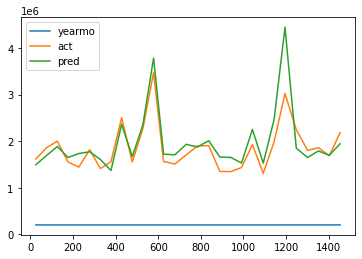

shop_id: 29


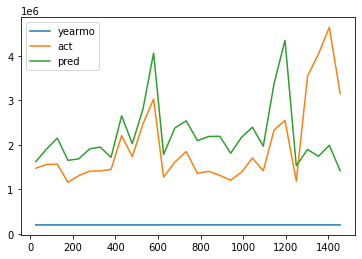

shop_id: 30


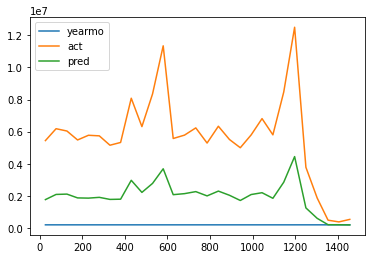

shop_id: 31


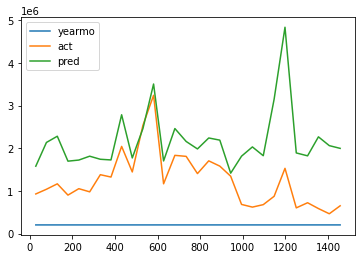

shop_id: 32


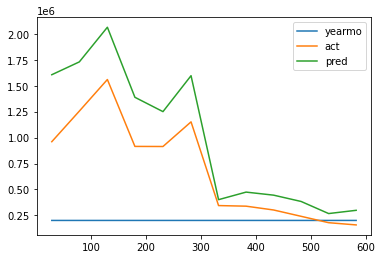

shop_id: 35


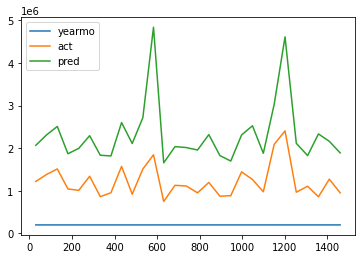

shop_id: 37


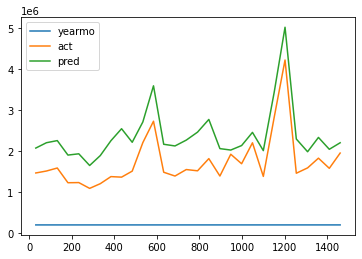

shop_id: 38


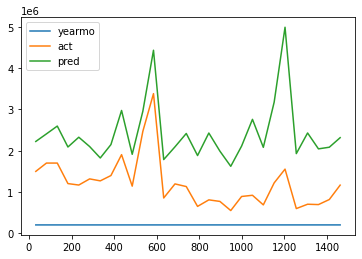

shop_id: 41


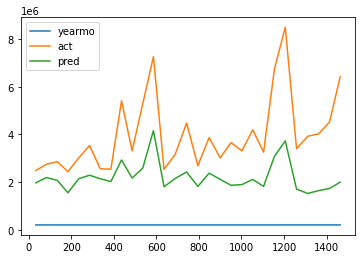

shop_id: 42


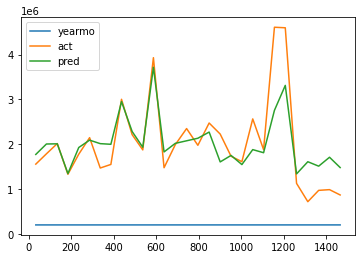

shop_id: 43


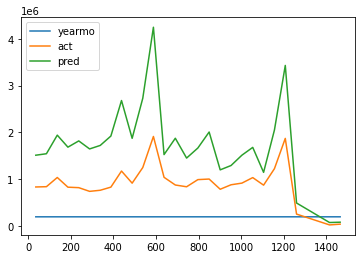

shop_id: 44


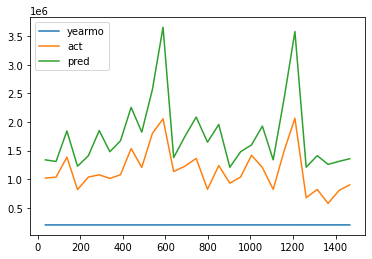

shop_id: 45


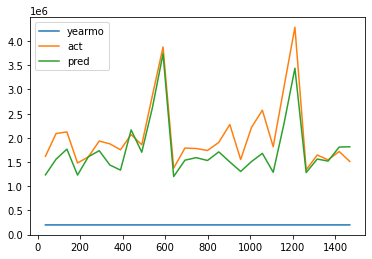

shop_id: 46


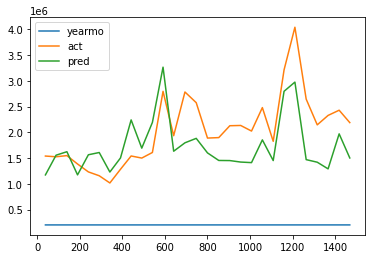

shop_id: 47


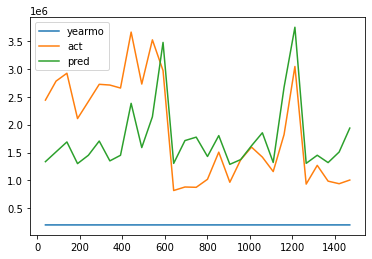

shop_id: 50


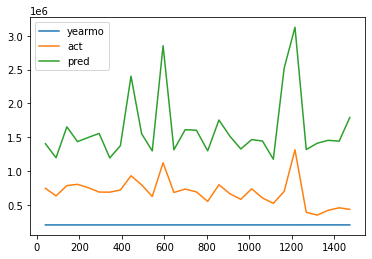

shop_id: 51


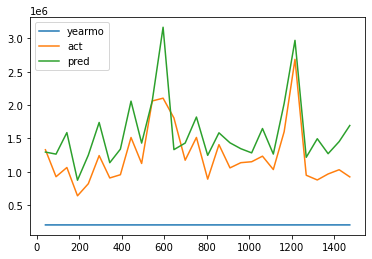

shop_id: 52


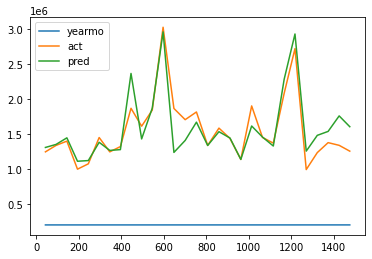

shop_id: 53


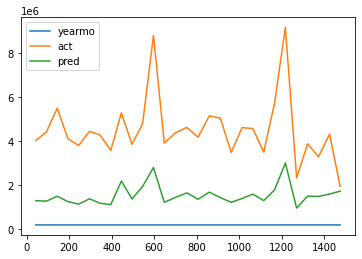

shop_id: 54


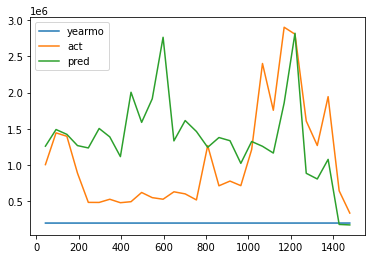

shop_id: 55


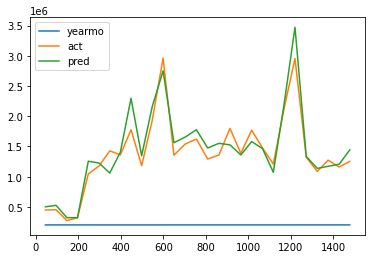

shop_id: 56


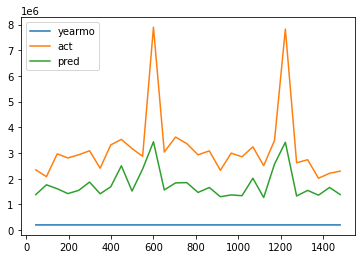

shop_id: 57


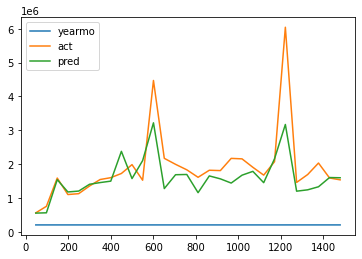

shop_id: 58


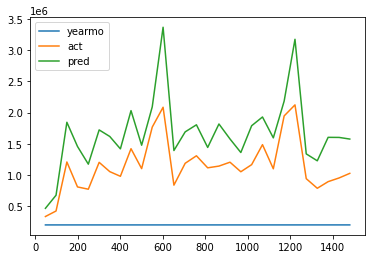

shop_id: 59


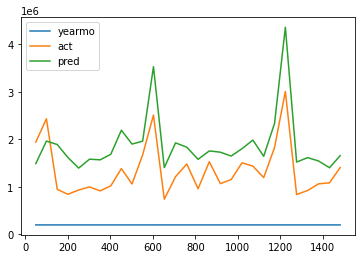

shop_id: 9


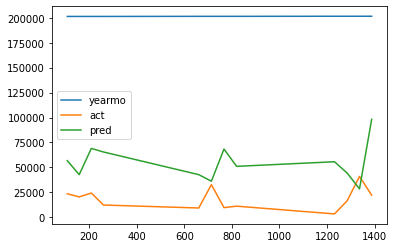

shop_id: 49


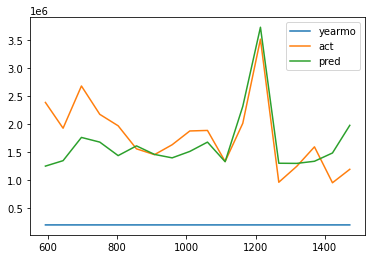

shop_id: 33


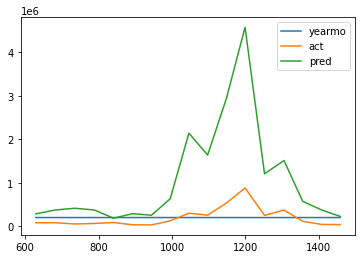

shop_id: 34


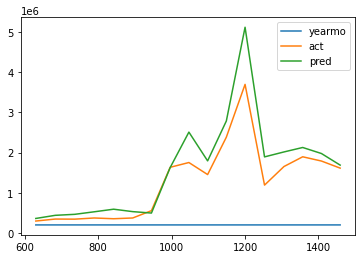

shop_id: 39


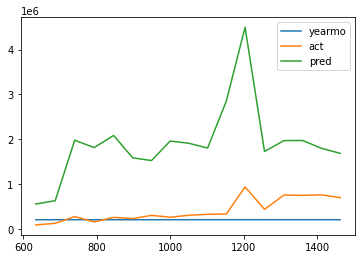

shop_id: 40


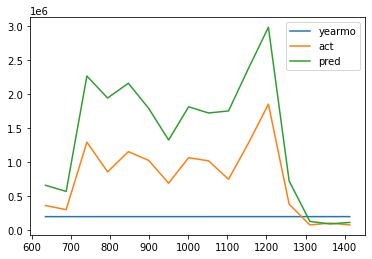

shop_id: 48


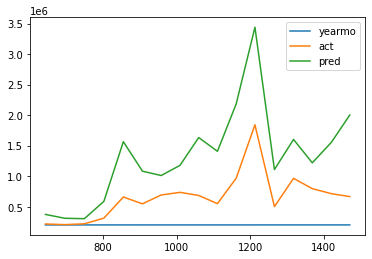

shop_id: 20


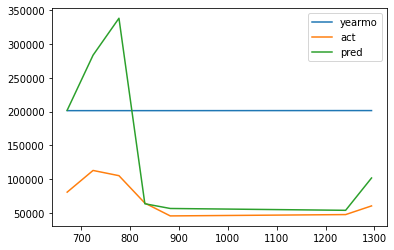

shop_id: 11


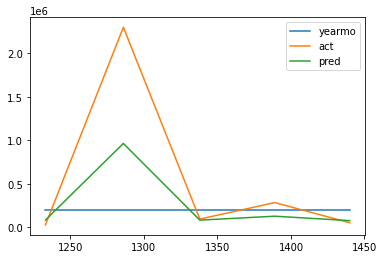

In [27]:
for i in storeMonthResultsTrain['shop_id'].unique():
    p = storeMonthResultsTrain[storeMonthResultsTrain['shop_id']==i]
    print('shop_id: %s'%(i))
    p[['yearmo', 'act', 'pred']].plot()
    plt.show()

In [28]:
chartData=storeMonthResultsTrain.append(storeMonthResultsTest)

shop_id: 11


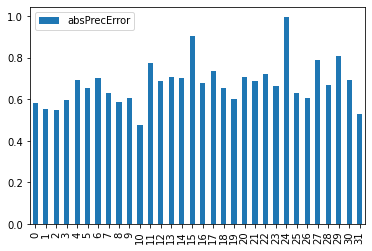

In [29]:
p = chartData.groupby(['yearmo', 'Flag'], as_index = False).mean()
print('shop_id: %s'%(i))
p[['absPrecError']].plot.bar()
plt.show()

In [30]:
p

,yearmo,Flag,shop_id,act,pred,precError,absPrecError,sqrdError
0,201301,Train,29.020000,1.474690e+06,1304269.875,-0.280910,0.584505,6.435670e+05
1,201302,Train,29.020000,1.717380e+06,1486815.250,-0.246790,0.553570,7.531699e+05
2,201303,Train,28.627451,1.748262e+06,1530506.125,-0.246087,0.547441,7.872141e+05
3,201304,Train,29.200000,1.350274e+06,1183473.750,-0.269932,0.594781,6.201933e+05
4,201305,Train,28.627451,1.449293e+06,1281998.125,-0.402833,0.691105,6.803071e+05
5,201306,Train,28.627451,1.589247e+06,1408448.875,-0.358281,0.656449,7.097913e+05
6,201307,Train,29.020000,1.455625e+06,1279551.375,-0.408116,0.701821,6.808996e+05
7,201308,Train,29.020000,1.489926e+06,1321805.750,-0.298103,0.629966,6.962594e+05
8,201309,Train,29.020000,2.148475e+06,1937198.750,-0.305373,0.585949,9.960036e+05
9,201310,Train,29.020000,1.682137e+06,1432514.250,-0.288612,0.604767,7.634103e+05


In [31]:
p.to_csv('../outputs/lstm_overall_trend_error.csv')